# 1. VERİ YOLU VE KÜTÜPHANELERİN YÜKLENMESİ

### 1.1- Data Setlerimizin Yolu:

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 - Gerekli Kütüphaneler

In [39]:
import numpy as np
from skimage import exposure, filters
import matplotlib.pyplot as plt
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.mixture import GaussianMixture
from shapely.geometry import Polygon
import cv2
from brisque import BRISQUE  # BRISQUE skoru için

# 2. ÖN İŞLEME (Skor)
## Pipeline 1: Min-Max Norm + Sobel Keskinleştirme + Gürültü Azaltma + Histogram Eşitleme + Gamma Dönüşümü

### 2.1 Ön işleme yöntemlerinin oluşturulması

En iyi Pipeline: 1 (BRISQUE Skoru: 18.81)


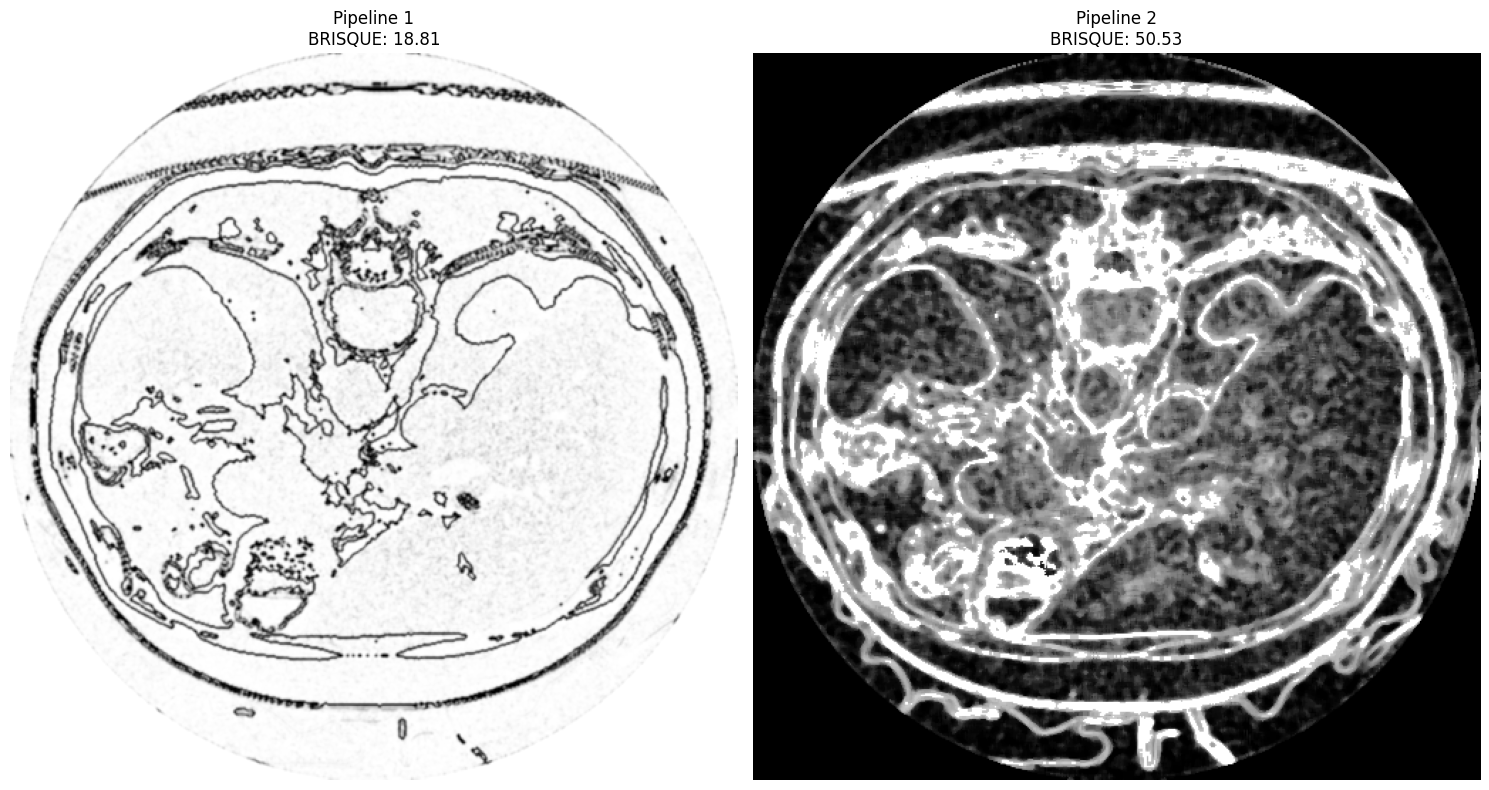

In [40]:


# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image, pipeline):
    if pipeline == 1:
        # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
        laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
        smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
        final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

        # Siyah ve beyaz renkleri tersine çevirme
        final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    elif pipeline == 2:
        # Pipeline 2: Min-Max Norm + Sobel Keskinleştirme + Median Blur + Histogram Eşitleme + Gamma Dönüşümü
        norm_image = normalize(image, method="minmax")
        sobel_image = sobel_sharpen((norm_image).astype(np.uint8))
        smoothed_image = cv2.medianBlur(sobel_image, 5)  # Daha güçlü Denoising
        final_image = cv2.equalizeHist(smoothed_image)  # Histogram Eşitleme
        final_image = apply_gamma(final_image, gamma=1.2).astype(np.uint8)  # Orta düzeyde parlaklık

    else:
        raise ValueError("Unsupported pipeline")

    return final_image

# Pipeline'ları değerlendirme
def main_pipeline_evaluation(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    pipelines = [1, 2]
    results = {}

    for pipeline in pipelines:
        # Pipeline'ı uygula
        processed_image = apply_pipeline(image, pipeline)

        # BRISQUE metriği ile değerlendirme
        processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
        brisque_score = BRISQUE().score(processed_image_3_channel)
        results[pipeline] = (processed_image, brisque_score)

    # En iyi pipeline'ı seç
    best_pipeline = min(results, key=lambda x: results[x][1])
    print(f"En iyi Pipeline: {best_pipeline} (BRISQUE Skoru: {results[best_pipeline][1]:.2f})")

    # Görüntüleri gösterme
    plt.figure(figsize=(8, 6))
    for i, pipeline in enumerate(pipelines, start=1):
        plt.subplot(1, len(pipelines), i)
        plt.title(f"Pipeline {pipeline}\nBRISQUE: {results[pipeline][1]:.2f}")
        plt.imshow(results[pipeline][0], cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Kullanım
image_path = "/content/drive/MyDrive/images/FLARE22_Tr_0001_slice_60.png"  # Görüntü yolunu doğru ayarlayın
main_pipeline_evaluation(image_path)


In [41]:
# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        raise ValueError("Unsupported normalization method")


# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0


### 2.2 Ön İşlemenin Uygulanması

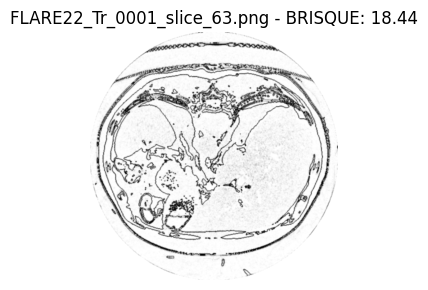

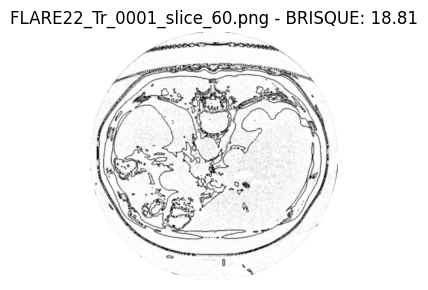

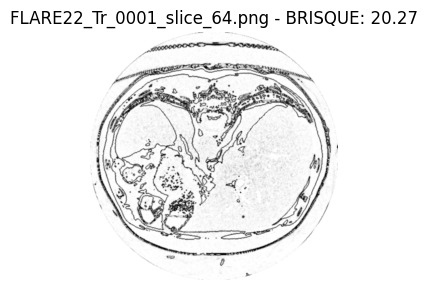

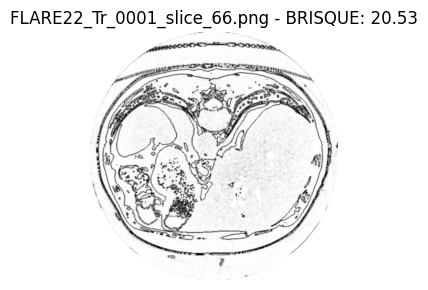

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from brisque import BRISQUE  # BRISQUE'yi doğru şekilde içe aktardığınızı varsayıyorum

# Normalizasyon fonksiyonu
def normalize(image, method="minmax"):
    if method == "minmax":
        return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    else:
        raise ValueError("Unsupported normalization method")

# Parlaklık ve zıtlık ayarlamaları için Gamma dönüşümü
def apply_gamma(image, gamma=1.0):
    return np.power(image / 255.0, gamma) * 255.0

# Sobel Keskinleştirme fonksiyonu
def sobel_sharpen(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Yatay kenar tespiti
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Dikey kenar tespiti
    sobel_image = cv2.magnitude(sobel_x, sobel_y)  # X ve Y kenarlarının birleşimi
    sobel_image = cv2.convertScaleAbs(sobel_image)  # Değerleri 8-bit'e dönüştür
    return sobel_image

# Canny Keskinleştirme fonksiyonu
def canny_sharpen(image):
    return cv2.Canny(image, 40, 90)  # Min-Max threshold (40, 90)

# Laplacian Keskinleştirme
def laplacian_sharpen(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Unsharp Mask fonksiyonu
def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 8.0)
    return cv2.addWeighted(image, 1.2, blurred, -0.2, 0)

# Bilateral Filtre fonksiyonu
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 30, 30)

# Adaptive Histogram Eşitleme uygulama
def apply_adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Pipeline fonksiyonları
def apply_pipeline(image):
    # Pipeline 1: Min-Max Norm + Adaptive Histogram Eşitleme + Laplacian Keskinleştirme + Gaussian Blur + Gamma Dönüşümü
    norm_image = normalize(image, method="minmax")
    adaptive_hist_eq_image = apply_adaptive_histogram_equalization((norm_image).astype(np.uint8))
    laplacian_image = laplacian_sharpen(adaptive_hist_eq_image)
    smoothed_image = cv2.GaussianBlur(laplacian_image, (3, 3), 0)
    final_image = apply_gamma(smoothed_image, gamma=1.8).astype(np.uint8)  # Daha parlak sonuç

    # Siyah ve beyaz renkleri tersine çevirme
    final_image = cv2.bitwise_not(final_image)  # Siyah ve beyazın tersini al

    return final_image

# Görüntüyü değerlendirme fonksiyonu
def evaluate_image(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Görüntü yüklenemedi: {image_path}")

    # Pipeline'ı uygula
    processed_image = apply_pipeline(image)

    # BRISQUE metriği ile değerlendirme
    processed_image_3_channel = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
    brisque_score = BRISQUE().score(processed_image_3_channel)

    return brisque_score, processed_image

# Belirtilen dizindeki ilk 100 görüntüyü işleme fonksiyonu
def evaluate_images_in_directory(directory_path):
    scores = []  # Skorları tutacak liste

    count = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Sadece görüntü dosyalarını işleme al
            image_path = os.path.join(directory_path, filename)
            brisque_score, processed_image = evaluate_image(image_path)
            scores.append((brisque_score, processed_image, filename))  # Skor ve görüntüyü kaydet

            count += 1

            if count >= 50:  # Sadece ilk 50 görüntüyü işle
                break

    # En düşük BRISQUE skoruna sahip olanları sıralama ve en düşük 5'u alma
    lowest_scores = sorted(scores, key=lambda x: x[0])[:5]

    return lowest_scores

# Kullanım
directory_path = "/content/drive/MyDrive/images"
big5img = evaluate_images_in_directory(directory_path)

# En düşük skora sahip görüntüleri gösterme
for score, image, filename in big5img:
    plt.figure(figsize=(3, 3))
    plt.title(f"{filename} - BRISQUE: {score:.2f}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 3. Desen Kodlama

### 3.1 En iyi 3 görselin ve labeli ile noktasal çarpımı

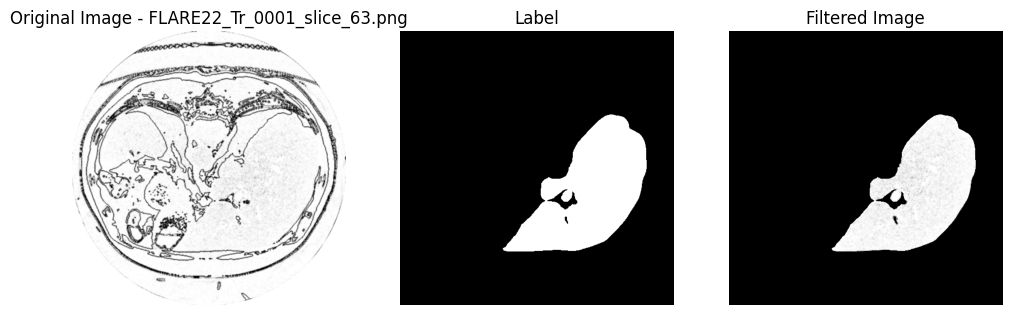

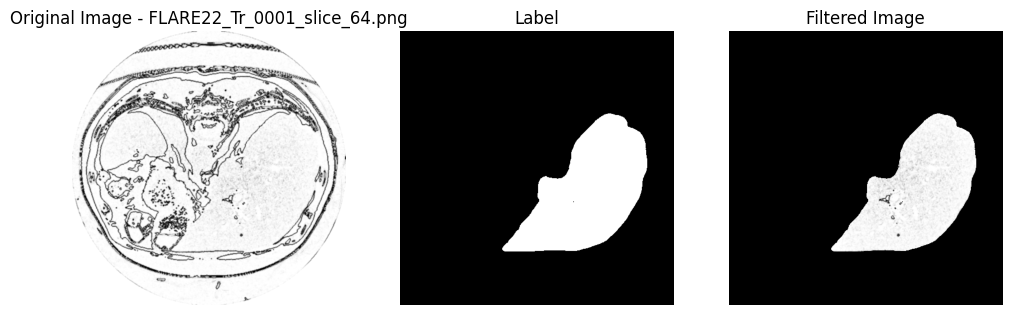

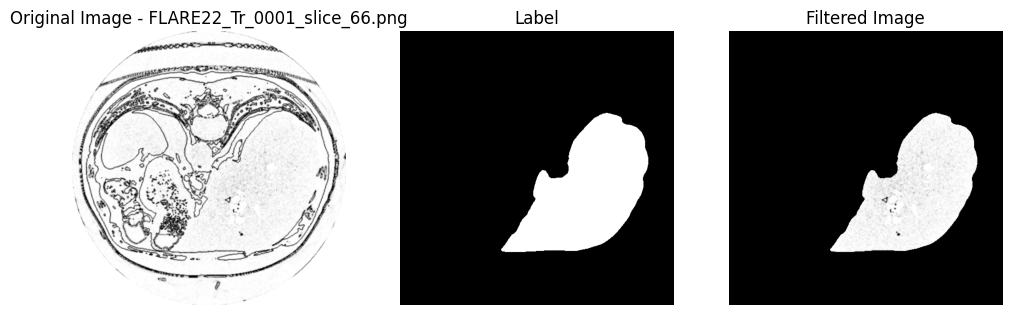

In [43]:
# Görsel ve label eşleştirme fonksiyonu
def process_big5img(lowest_scores, label_directory):
    count = 0
    for score, image, filename in lowest_scores:
        count += 1

        # Etiketi eşleştir
        label_path = os.path.join(label_directory, filename)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if label is None:
            print(f"Warning: Label not found for {filename}")
            continue

        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)

        # Görselleri çizdir
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image - {filename}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Filtered Image")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

        plt.show()
        if count >= 5:  # Sadece ilk 5 görüntüyü işle
            break

# Label dizini
label_directory_path = "/content/drive/MyDrive/labels"

# En düşük BRISQUE skorlarına sahip görsellerle işlem yap
process_big5img(big5img, label_directory_path)


### 3.2 Kullanılacak metodların oluşturulması

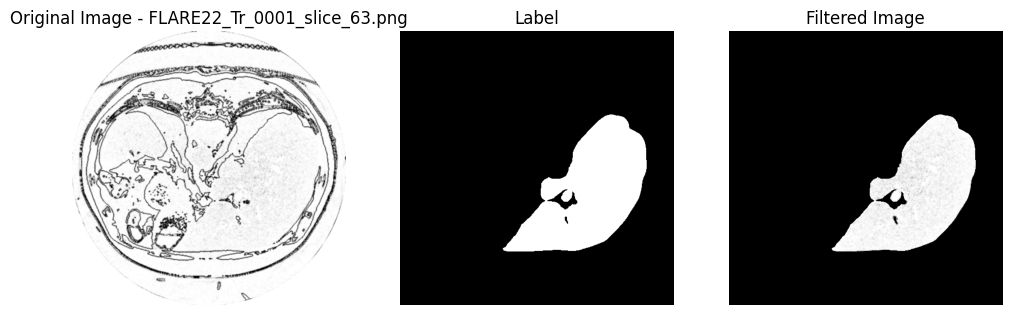

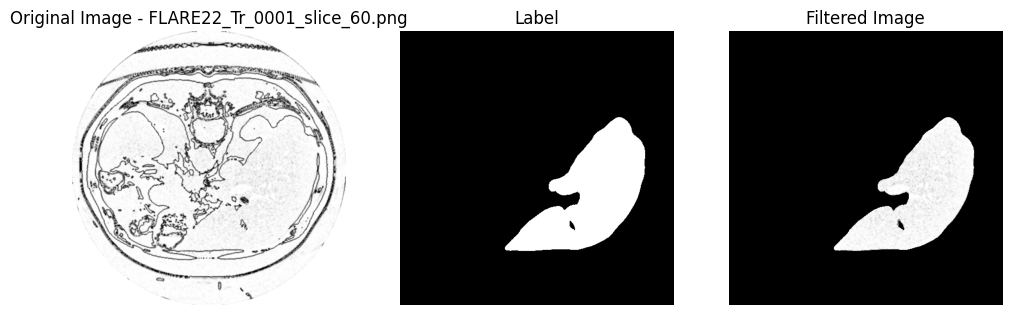

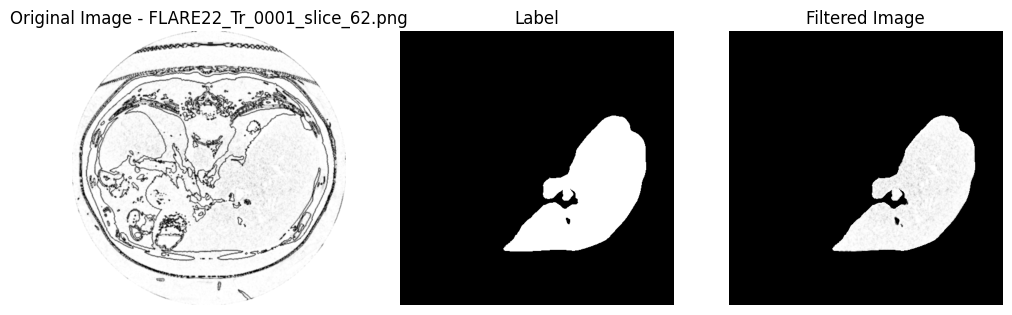

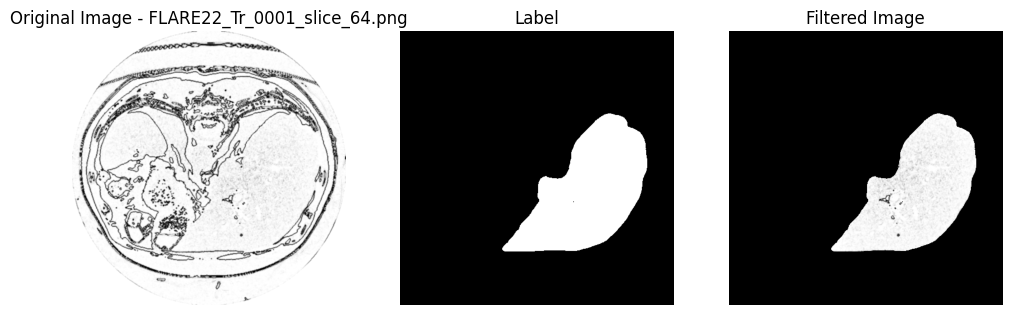

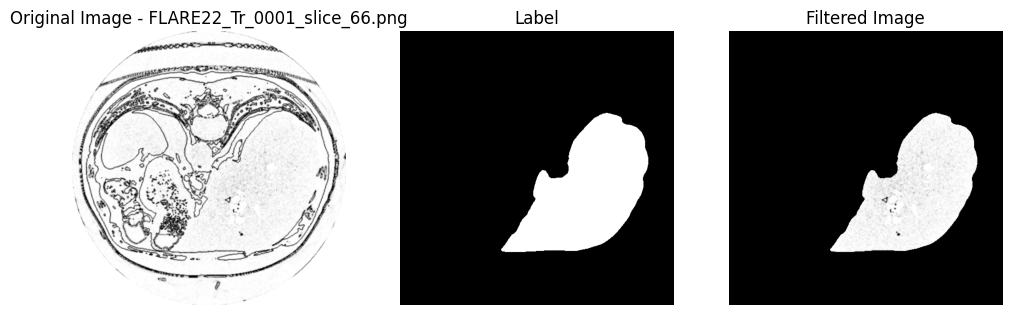

In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_big5img(lowest_scores, label_directory, output_directory):
    count = 0
    for score, image, filename in lowest_scores:
        count += 1

        # Etiketi eşleştir
        label_path = os.path.join(label_directory, filename)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if label is None:
            print(f"Warning: Label not found for {filename}")
            continue

        # Normalize label (0 veya 1'e dönüştür)
        label = (label > 0).astype(np.uint8)
        filtered_image = cv2.bitwise_and(image, image, mask=label)

        # Görselleri çizdir
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image - {filename}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Filtered Image")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

        plt.show()

        # Kaydetmek için filtered_image'ı output dizinine yaz
        output_path = os.path.join(output_directory, f"filtered_{filename}")
        cv2.imwrite(output_path, filtered_image)

        if count >= 5:  # Sadece ilk 5 görüntüyü işle
            break

# Label dizini
label_directory_path = "/content/drive/MyDrive/labels"
# Filtrelenmiş görsellerin kaydedileceği dizin
output_directory_path = "/content/drive/MyDrive/filtered_images"

# Eğer output dizini mevcut değilse oluştur
if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# En düşük BRISQUE skorlarına sahip görsellerle işlem yap
process_big5img(big5img, label_directory_path, output_directory_path)


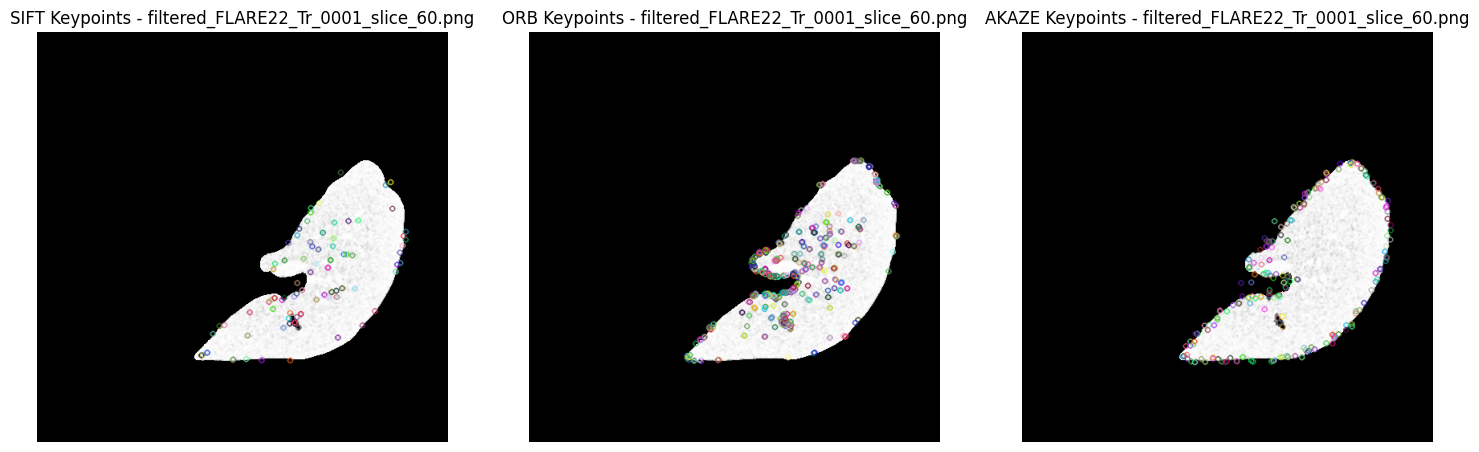

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_60


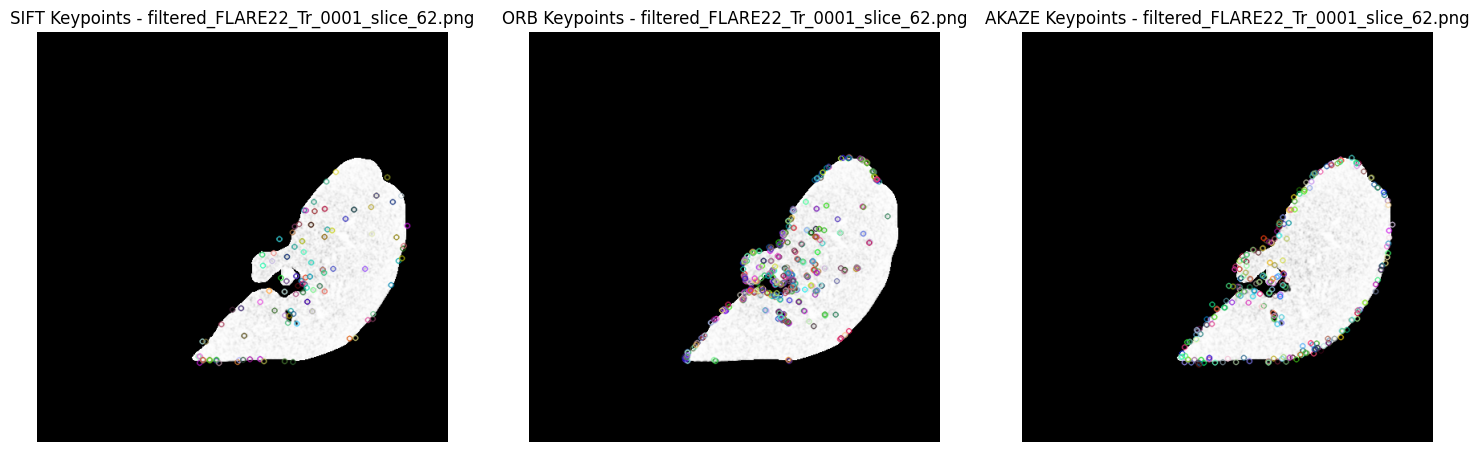

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_62


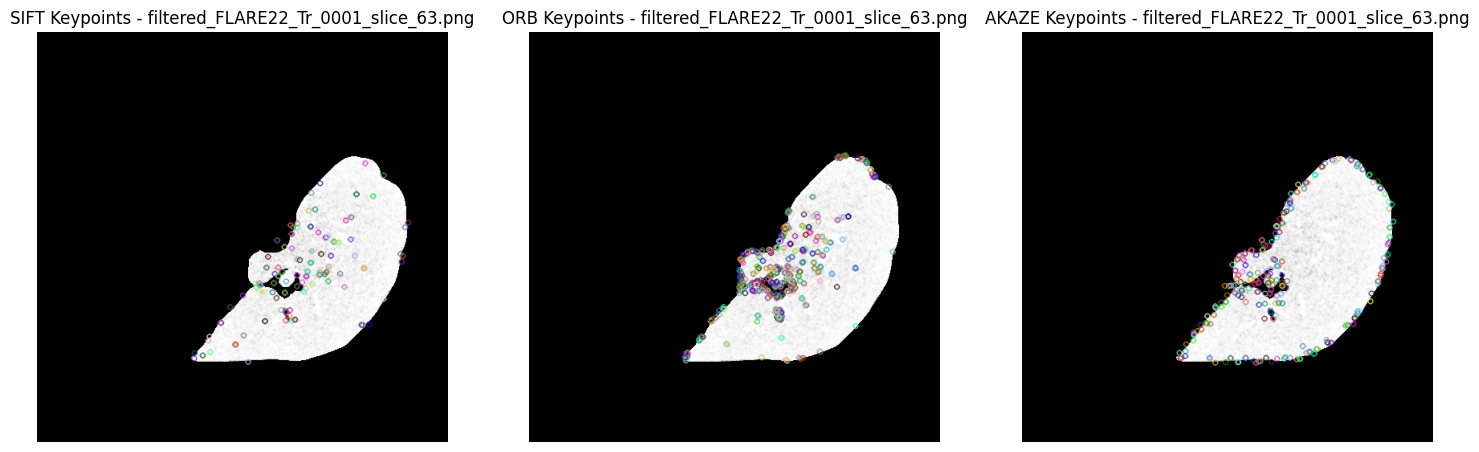

Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_63


Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_64


Keypoints and descriptors saved for filtered_FLARE22_Tr_0001_slice_66


In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Görsel dosya yolları
image_paths = [
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_62.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_63.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_64.png',
    '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_66.png'
]

# AKAZE, ORB, SIFT algoritmalarını başlat
akaze = cv2.AKAZE_create()
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# Kaydedilecek dizinleri kontrol et ve oluştur
output_directory = '/mnt/data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Her bir görsel için işlemi uygula
for image_path in image_paths:
    # Görüntüyü yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Anahtar noktaları ve tanımlayıcıları tespit et
    keypoints_sift, descriptors_sift = sift.detectAndCompute(image, None)
    keypoints_orb, descriptors_orb = orb.detectAndCompute(image, None)
    keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(image, None)

    # Anahtar noktaları görüntü üzerinde işaretle
    image_with_keypoints_sift = cv2.drawKeypoints(image, keypoints_sift, None)
    image_with_keypoints_orb = cv2.drawKeypoints(image, keypoints_orb, None)
    image_with_keypoints_akaze = cv2.drawKeypoints(image, keypoints_akaze, None)

    # Görselleri yan yana göster
    plt.figure(figsize=(18, 6))

    # SIFT Görseli
    plt.subplot(1, 3, 1)
    plt.imshow(image_with_keypoints_sift)
    plt.title(f"SIFT Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    # ORB Görseli
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_keypoints_orb)
    plt.title(f"ORB Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    # AKAZE Görseli
    plt.subplot(1, 3, 3)
    plt.imshow(image_with_keypoints_akaze)
    plt.title(f"AKAZE Keypoints - {image_path.split('/')[-1]}")
    plt.axis('off')

    plt.show()

    # Kaydedilecek dosya yolları
    base_filename = image_path.split('/')[-1].replace('.png', '')

    # Anahtar noktaları görsellerini kaydet
    output_keypoints_sift_path = os.path.join(output_directory, f'{base_filename}_keypoints_sift.png')
    cv2.imwrite(output_keypoints_sift_path, image_with_keypoints_sift)

    output_keypoints_orb_path = os.path.join(output_directory, f'{base_filename}_keypoints_orb.png')
    cv2.imwrite(output_keypoints_orb_path, image_with_keypoints_orb)

    output_keypoints_akaze_path = os.path.join(output_directory, f'{base_filename}_keypoints_akaze.png')
    cv2.imwrite(output_keypoints_akaze_path, image_with_keypoints_akaze)

    # Tanımlayıcıları kaydet
    output_descriptors_sift_path = os.path.join(output_directory, f'{base_filename}_descriptors_sift.npy')
    np.save(output_descriptors_sift_path, descriptors_sift)

    output_descriptors_orb_path = os.path.join(output_directory, f'{base_filename}_descriptors_orb.npy')
    np.save(output_descriptors_orb_path, descriptors_orb)

    output_descriptors_akaze_path = os.path.join(output_directory, f'{base_filename}_descriptors_akaze.npy')
    np.save(output_descriptors_akaze_path, descriptors_akaze)

    print(f"Keypoints and descriptors saved for {base_filename}")


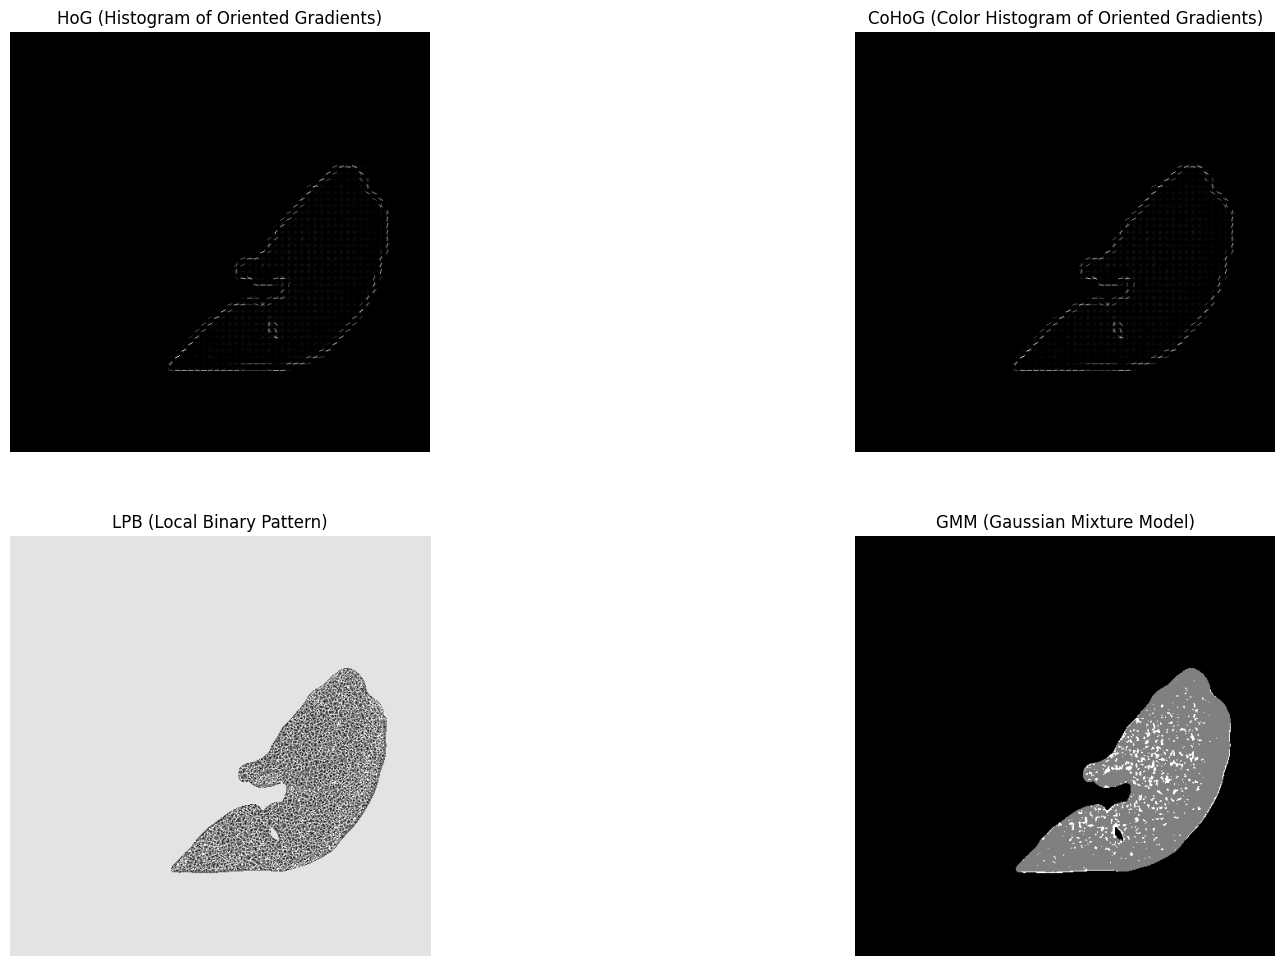

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler

# Görüntüyü yükle
image_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 1. HoG (Histogram of Oriented Gradients)
def compute_hog(image):
    fd, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

# 2. CoHoG (Color Histogram of Oriented Gradients)
def compute_cohog(image):
    # Görüntüyü BGR'den RGB'ye çevir (HoG RGB üzerinde çalışır)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # HoG'yi her kanal için ayrı ayrı hesapla
    fd_r, hog_r = hog(image_rgb[:, :, 0], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_g, hog_g = hog(image_rgb[:, :, 1], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_b, hog_b = hog(image_rgb[:, :, 2], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Renk kanallarını birleştir
    hog_image = np.sqrt(hog_r**2 + hog_g**2 + hog_b**2)  # Kanal birleşimi (magnitude)
    return hog_image

# 3. LPB (Local Binary Pattern)
def compute_lbp(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    return lbp

# 4. GMM (Gaussian Mixture Model)
def compute_gmm(image):
    # Görüntüyü 2D şekle getirme
    image_reshaped = image.reshape((-1, 1))
    gmm = GaussianMixture(n_components=3)
    gmm.fit(image_reshaped)
    gmm_labels = gmm.predict(image_reshaped)
    gmm_image = gmm_labels.reshape(image.shape)
    return gmm_image

# Görselleştirme
plt.figure(figsize=(20, 12))

# HoG
hog_image = compute_hog(image)
plt.subplot(2, 2, 1)
plt.imshow(hog_image, cmap='gray')
plt.title("HoG (Histogram of Oriented Gradients)")
plt.axis('off')

# CoHoG
cohog_image = compute_cohog(image)
plt.subplot(2, 2, 2)
plt.imshow(cohog_image, cmap='gray')
plt.title("CoHoG (Color Histogram of Oriented Gradients)")
plt.axis('off')

# LPB
lbp_image = compute_lbp(image)
plt.subplot(2, 2, 3)
plt.imshow(lbp_image, cmap='gray')
plt.title("LPB (Local Binary Pattern)")
plt.axis('off')

# GMM
gmm_image = compute_gmm(image)
plt.subplot(2, 2, 4)
plt.imshow(gmm_image, cmap='gray')
plt.title("GMM (Gaussian Mixture Model)")
plt.axis('off')

plt.show()


In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import os

# Görüntü dosya yolu (sadece '60' ile biten dosya)
image_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# AKAZE algoritmasını başlat
akaze = cv2.AKAZE_create()

# Anahtar noktaları ve tanımlayıcıları tespit et
keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(image, None)

# HoG hesaplama fonksiyonu
def compute_hog(image):
    fd, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

# CoHoG hesaplama fonksiyonu
def compute_cohog(image):
    # Görüntüyü BGR'den RGB'ye çevir (HoG RGB üzerinde çalışır)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # HoG'yi her kanal için ayrı ayrı hesapla
    fd_r, hog_r = hog(image_rgb[:, :, 0], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_g, hog_g = hog(image_rgb[:, :, 1], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_b, hog_b = hog(image_rgb[:, :, 2], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Renk kanallarını birleştir
    hog_image = np.sqrt(hog_r**2 + hog_g**2 + hog_b**2)  # Kanal birleşimi (magnitude)
    return hog_image

# Morfolojik Operasyonlar (Anahtar noktaları birleştirme)
def apply_morphological_operations(image, keypoints):
    # Görüntüyü ikili hale getir (beyaz, siyah)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Morfolojik işlemlerle poligon oluştur
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Anahtar noktaları için çevreyi çiz
    points = np.array([kp.pt for kp in keypoints], dtype=np.int32)
    hull = cv2.convexHull(points)  # Konveks kısmi çevre (poligon)

    # Görüntüye çevreyi çiz
    cv2.polylines(morphed, [hull], isClosed=True, color=(255, 255, 255), thickness=2)
    return morphed, hull

# IoU hesaplama
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# HoG ve CoHoG hesaplama
hog_image = compute_hog(image)
cohog_image = compute_cohog(image)

# Poligon oluşturma ve IoU hesaplama
morphed_hog, hull_hog = apply_morphological_operations(hog_image, keypoints_akaze)
morphed_cohog, hull_cohog = apply_morphological_operations(cohog_image, keypoints_akaze)

# Görselleştirme
plt.figure(figsize=(18, 12))

# AKAZE + HoG Sonuçları
plt.subplot(1, 2, 1)
plt.imshow(morphed_hog, cmap='gray')
plt.title("AKAZE + HoG")
plt.axis('off')

# AKAZE + CoHoG Sonuçları
plt.subplot(1, 2, 2)
plt.imshow(morphed_cohog, cmap='gray')
plt.title("AKAZE + CoHoG")
plt.axis('off')

plt.show()

# IoU hesaplama (örnek: Ground truth maskesi olarak morfolojik işlemle elde edilen poligon)
iou_hog = calculate_iou(morphed_hog, morphed_hog)  # Burada ground truth ile karşılaştırma yapılabilir
iou_cohog = calculate_iou(morphed_cohog, morphed_cohog)

print(f"IoU for AKAZE + HoG: {iou_hog}")
print(f"IoU for AKAZE + CoHoG: {iou_cohog}")


IoU for AKAZE + HoG: 1.0
IoU for AKAZE + CoHoG: 1.0


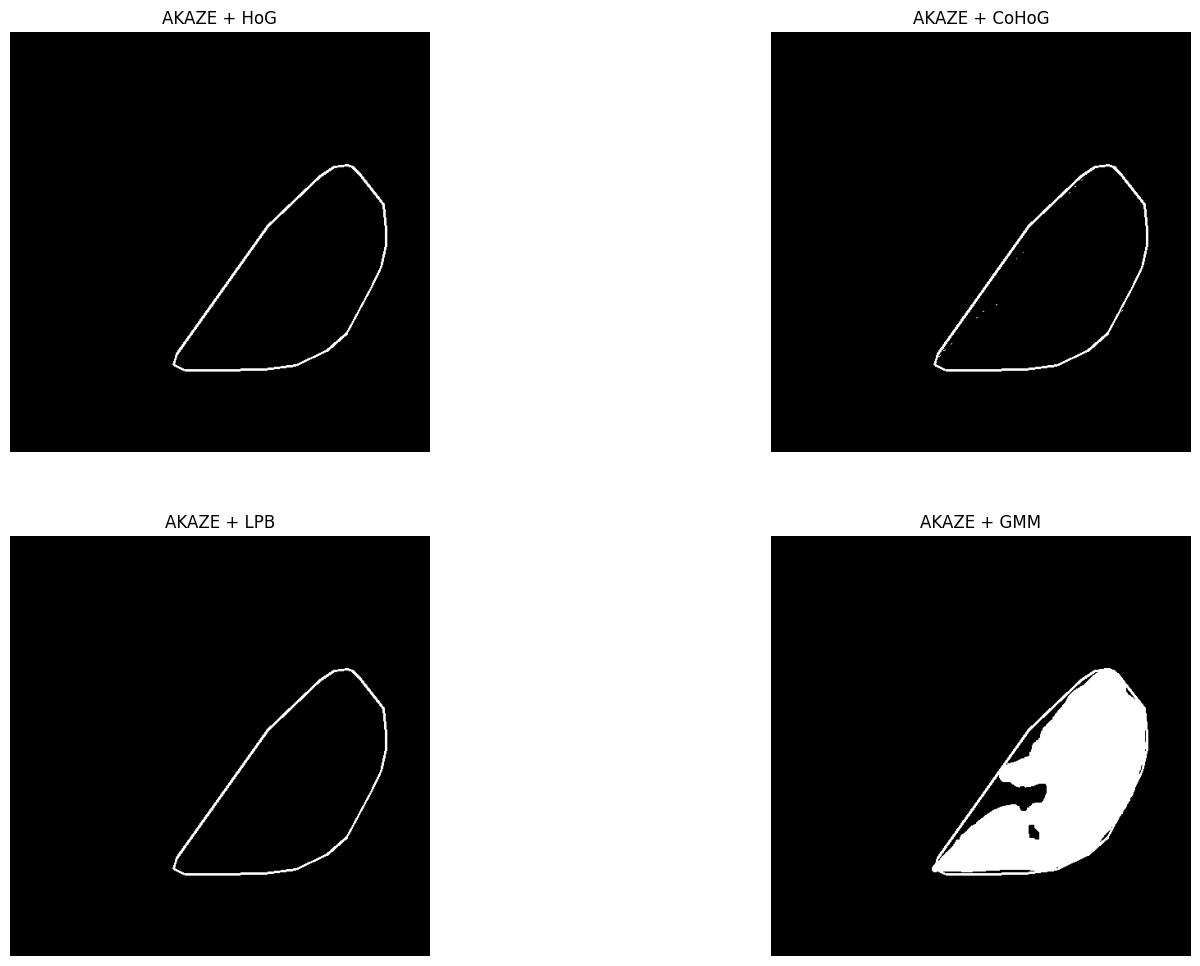

IoU for AKAZE + HoG: 0.016117749927134946
IoU for AKAZE + CoHoG: 0.01657925407925408
IoU for AKAZE + LPB: 0.016117749927134946
IoU for AKAZE + GMM: 0.9325174825174826


In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.mixture import GaussianMixture
from shapely.geometry import Polygon
from shapely.validation import make_valid

# Görüntü dosya yolu (sadece '60' ile biten dosya)
image_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# AKAZE algoritmasını başlat
akaze = cv2.AKAZE_create()

# Anahtar noktaları ve tanımlayıcıları tespit et
keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(image, None)

# HoG hesaplama fonksiyonu
def compute_hog(image):
    fd, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

# CoHoG hesaplama fonksiyonu
def compute_cohog(image):
    # Görüntüyü BGR'den RGB'ye çevir (HoG RGB üzerinde çalışır)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # HoG'yi her kanal için ayrı ayrı hesapla
    fd_r, hog_r = hog(image_rgb[:, :, 0], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_g, hog_g = hog(image_rgb[:, :, 1], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_b, hog_b = hog(image_rgb[:, :, 2], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Renk kanallarını birleştir
    hog_image = np.sqrt(hog_r**2 + hog_g**2 + hog_b**2)  # Kanal birleşimi (magnitude)
    return hog_image

# LPB hesaplama fonksiyonu
def compute_lbp(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    return lbp

# GMM hesaplama fonksiyonu
def compute_gmm(image):
    # Görüntüyü 2D şekle getirme
    image_reshaped = image.reshape((-1, 1))
    gmm = GaussianMixture(n_components=3)
    gmm.fit(image_reshaped)
    gmm_labels = gmm.predict(image_reshaped)
    gmm_image = gmm_labels.reshape(image.shape)
    return gmm_image

# Morfolojik Operasyonlar (Anahtar noktaları birleştirme)
def apply_morphological_operations(image, keypoints):
    # Görüntüyü ikili hale getir (beyaz, siyah)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Morfolojik işlemlerle poligon oluştur
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Anahtar noktaları için çevreyi çiz
    points = np.array([kp.pt for kp in keypoints], dtype=np.int32)
    hull = cv2.convexHull(points)  # Konveks kısmi çevre (poligon)

    # Görüntüye çevreyi çiz
    cv2.polylines(morphed, [hull], isClosed=True, color=(255, 255, 255), thickness=2)
    return morphed, hull

# IoU hesaplama
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# HoG, CoHoG, LPB ve GMM hesaplama
hog_image = compute_hog(image)
cohog_image = compute_cohog(image)
lbp_image = compute_lbp(image)
gmm_image = compute_gmm(image)

# GMM için eşikleme (binarization)
gmm_image_binary = np.where(gmm_image == 1, 255, 0).astype(np.uint8)

# Poligon oluşturma ve IoU hesaplama
morphed_hog, hull_hog = apply_morphological_operations(hog_image, keypoints_akaze)
morphed_cohog, hull_cohog = apply_morphological_operations(cohog_image, keypoints_akaze)
morphed_lbp, hull_lbp = apply_morphological_operations(lbp_image, keypoints_akaze)
morphed_gmm, hull_gmm = apply_morphological_operations(gmm_image_binary, keypoints_akaze)

# Görselleştirme
plt.figure(figsize=(18, 12))

# AKAZE + HoG Sonuçları
plt.subplot(2, 2, 1)
plt.imshow(morphed_hog, cmap='gray')
plt.title("AKAZE + HoG")
plt.axis('off')

# AKAZE + CoHoG Sonuçları
plt.subplot(2, 2, 2)
plt.imshow(morphed_cohog, cmap='gray')
plt.title("AKAZE + CoHoG")
plt.axis('off')

# AKAZE + LPB Sonuçları
plt.subplot(2, 2, 3)
plt.imshow(morphed_lbp, cmap='gray')
plt.title("AKAZE + LPB")
plt.axis('off')

# AKAZE + GMM Sonuçları
plt.subplot(2, 2, 4)
plt.imshow(morphed_gmm, cmap='gray')
plt.title("AKAZE + GMM")
plt.axis('off')

plt.show()

# Label (Ground Truth) Yükle
label_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'  # Burada label_path'i size uygun şekilde düzenleyin
label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
label_image = np.where(label_image > 0, 1, 0)  # Binary formata çevir

# IoU hesaplama (örnek: Ground truth maskesi olarak morfolojik işlemle elde edilen poligon)
iou_hog = calculate_iou(morphed_hog, label_image)
iou_cohog = calculate_iou(morphed_cohog, label_image)
iou_lbp = calculate_iou(morphed_lbp, label_image)
iou_gmm = calculate_iou(morphed_gmm, label_image)

print(f"IoU for AKAZE + HoG: {iou_hog}")
print(f"IoU for AKAZE + CoHoG: {iou_cohog}")
print(f"IoU for AKAZE + LPB: {iou_lbp}")
print(f"IoU for AKAZE + GMM: {iou_gmm}")


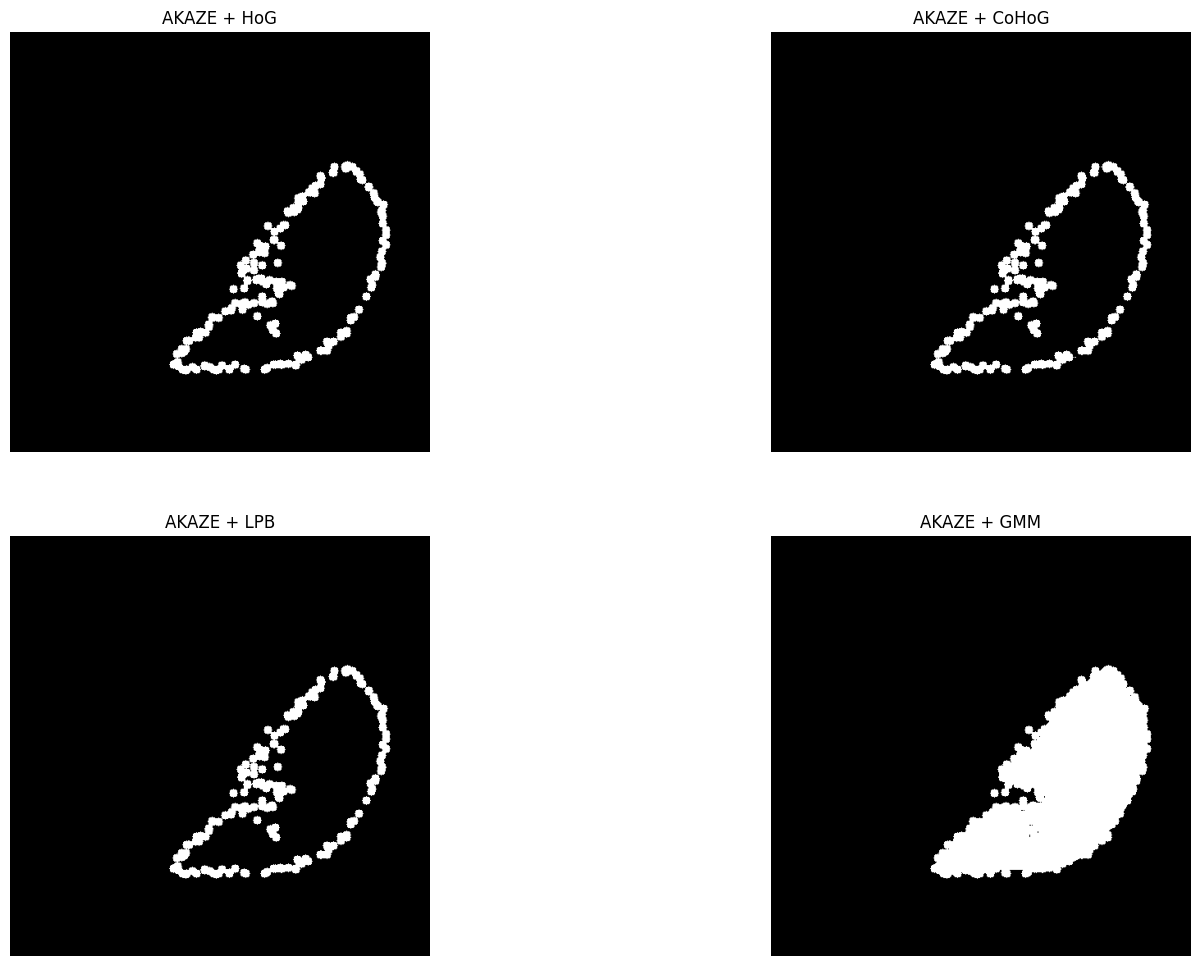

IoU for AKAZE + HoG: 0.16095131229645038
IoU for AKAZE + CoHoG: 0.16099283016802585
IoU for AKAZE + LPB: 0.16095131229645038
IoU for AKAZE + GMM: 0.8868879827034128


In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.mixture import GaussianMixture
from shapely.geometry import Polygon
from shapely.validation import make_valid

# Görüntü dosya yolu (sadece '60' ile biten dosya)
image_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# AKAZE algoritmasını başlat
akaze = cv2.AKAZE_create()

# Anahtar noktaları ve tanımlayıcıları tespit et
keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(image, None)

# HoG hesaplama fonksiyonu
def compute_hog(image):
    fd, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

# CoHoG hesaplama fonksiyonu
def compute_cohog(image):
    # Görüntüyü BGR'den RGB'ye çevir (HoG RGB üzerinde çalışır)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # HoG'yi her kanal için ayrı ayrı hesapla
    fd_r, hog_r = hog(image_rgb[:, :, 0], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_g, hog_g = hog(image_rgb[:, :, 1], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    fd_b, hog_b = hog(image_rgb[:, :, 2], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Renk kanallarını birleştir
    hog_image = np.sqrt(hog_r**2 + hog_g**2 + hog_b**2)  # Kanal birleşimi (magnitude)
    return hog_image

# LPB hesaplama fonksiyonu
def compute_lbp(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    return lbp

# GMM hesaplama fonksiyonu
def compute_gmm(image):
    # Görüntüyü 2D şekle getirme
    image_reshaped = image.reshape((-1, 1))
    gmm = GaussianMixture(n_components=3)
    gmm.fit(image_reshaped)
    gmm_labels = gmm.predict(image_reshaped)
    gmm_image = gmm_labels.reshape(image.shape)
    return gmm_image

# Morfolojik Operasyonlar (Anahtar noktaları birleştirme)
def apply_morphological_operations(image, keypoints):
    # Görüntüyü ikili hale getir (beyaz, siyah)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Morfolojik işlemlerle poligon oluştur
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Anahtar noktalar etrafında daha geniş bir bölgeyi kapsayacak şekilde genişletme
    keypoint_coords = np.array([kp.pt for kp in keypoints], dtype=np.int32)

    # Anahtar noktaların çevresinde belirli bir alanı etkileme
    for point in keypoint_coords:
        cv2.circle(morphed, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)

    return morphed

# IoU hesaplama
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# HoG, CoHoG, LPB ve GMM hesaplama
hog_image = compute_hog(image)
cohog_image = compute_cohog(image)
lbp_image = compute_lbp(image)
gmm_image = compute_gmm(image)

# GMM için eşikleme (binarization)
gmm_image_binary = np.where(gmm_image == 1, 255, 0).astype(np.uint8)

# Poligon oluşturma ve IoU hesaplama
morphed_hog = apply_morphological_operations(hog_image, keypoints_akaze)
morphed_cohog = apply_morphological_operations(cohog_image, keypoints_akaze)
morphed_lbp = apply_morphological_operations(lbp_image, keypoints_akaze)
morphed_gmm = apply_morphological_operations(gmm_image_binary, keypoints_akaze)

# Görselleştirme
plt.figure(figsize=(18, 12))

# AKAZE + HoG Sonuçları
plt.subplot(2, 2, 1)
plt.imshow(morphed_hog, cmap='gray')
plt.title("AKAZE + HoG")
plt.axis('off')

# AKAZE + CoHoG Sonuçları
plt.subplot(2, 2, 2)
plt.imshow(morphed_cohog, cmap='gray')
plt.title("AKAZE + CoHoG")
plt.axis('off')

# AKAZE + LPB Sonuçları
plt.subplot(2, 2, 3)
plt.imshow(morphed_lbp, cmap='gray')
plt.title("AKAZE + LPB")
plt.axis('off')

# AKAZE + GMM Sonuçları
plt.subplot(2, 2, 4)
plt.imshow(morphed_gmm, cmap='gray')
plt.title("AKAZE + GMM")
plt.axis('off')

plt.show()

# Label (Ground Truth) Yükle
label_path = '/content/drive/MyDrive/filtered_images/filtered_FLARE22_Tr_0001_slice_60.png'  # Burada label_path'i size uygun şekilde düzenleyin
label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
label_image = np.where(label_image > 0, 1, 0)  # Binary formata çevir

# IoU hesaplama (örnek: Ground truth maskesi olarak morfolojik işlemle elde edilen poligon)
iou_hog = calculate_iou(morphed_hog, label_image)
iou_cohog = calculate_iou(morphed_cohog, label_image)
iou_lbp = calculate_iou(morphed_lbp, label_image)
iou_gmm = calculate_iou(morphed_gmm, label_image)

print(f"IoU for AKAZE + HoG: {iou_hog}")
print(f"IoU for AKAZE + CoHoG: {iou_cohog}")
print(f"IoU for AKAZE + LPB: {iou_lbp}")
print(f"IoU for AKAZE + GMM: {iou_gmm}")
